In [1]:
# Import all package will be used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dataframe_image as dfi
import time
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoLars
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Perceptron

## **Data Preparation**  
1. Read data as Data frame.  
2. Read all features and split data into Train, Valdation, Test dataset.


In [2]:
# read 'csv' file as a data frame and show how the data looks like
Elec_info = pd.read_csv("coursework_other.csv")
display(Elec_info)

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90
...,...,...,...,...,...
9563,16.65,49.69,1014.01,91.00,460.03
9564,13.19,39.18,1023.67,66.78,469.62
9565,31.32,74.33,1012.92,36.48,429.57
9566,24.48,69.45,1013.86,62.39,435.74


In [4]:
# Seprate the last column as outcomes, which also the value we need to predict
# Transform the data frame to a numpy for spliting
X = Elec_info.iloc[:, :-1].to_numpy()
Y = Elec_info.iloc[:, -1].to_numpy()

# Split all data into Xtest, Xtrain, Ytrain, Ytestabs
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=1729)

# Generate a cross-validation dataset
cv = KFold(n_splits=5, random_state=1729, shuffle=True)

## **Method & Functions**
**All those method are return MSE in train data and validation data and the optimal model.**
1. PolynomialFeatures
2. Base Line Regression method
3. Ridge Regression with cross-validation
4. Decision Tree Regression method
5. Support Vector Regression
6. KernelRidgeRegression  


In [5]:
# Define a function to transfer features into a Polynomial Features
def PolynomialFeaturesProcess(degree, Xtrain, Xval):
    PRM = PolynomialFeatures(degree = degree)
    Xtra_PF_ft = PRM.fit_transform(Xtrain)
    Xval_PF_ft = PRM.fit_transform(Xval)
    return Xtra_PF_ft, Xval_PF_ft, PRM

In [6]:
# Define a Base-line function, which will use to compare with algorithms I chosen
# The parameter: cv(cross-validation), strategy (Use to decide the stratege for Dummy Regression)
def BaseLine_Regression(cv, strategies, Xtrain, Ytrain):
    
    DRM_train_accuracy = []
    DRM_val_accuracy = []
    # Baseline Prediction model
    for strategy in strategies:
        DRM = DummyRegressor(strategy=strategy, quantile=0.25, constant=450)
        MSE_train = []
        MSE_val = []

        # Go through all cross-cvalidation data set
        for train_set, val_set in cv.split(Xtrain):
            Xtra, Xval, Ytra, Yval = Xtrain[train_set], Xtrain[val_set], Ytrain[train_set], Ytrain[val_set]
            # fit the model on the current split of data 
            DR_model=DRM.fit(Xtra, Ytra)
            # make predictions 
            Y_pred_tra=DR_model.predict(Xtra)
            #print(Y_pred_tra)
            Y_pred_val=DR_model.predict(Xval)
            # calculate training and validation accuracy and store 
            MSE_train.append(mean_squared_error(Ytra,Y_pred_tra))
            MSE_val.append(mean_squared_error(Yval,Y_pred_val))

        # Calculate the mean MSE for each whole CV
        DRM_train_accuracy.append(np.mean(MSE_train))
        DRM_val_accuracy.append(np.mean(MSE_val))
    
    Best_Hyperpara = strategies[np.argmin(DRM_val_accuracy)]
    Best_MSE = min(DRM_val_accuracy)
    
    DRM = DummyRegressor(strategy=Best_Hyperpara, quantile=0.3, constant=450)
    Best_DR_model=DRM.fit(Xtra, Ytra)      
    
    return DRM_train_accuracy, DRM_val_accuracy, Best_DR_model

In [7]:
# Define a function use the Ridge Regression to fit data and predict results
# The paramters are: CV(cross-validation), HyperParameter(alpha in RR), 
#                    X train data, Y train data, polyfeatures choise(True will call PolyniomialFeaturesProcess funtion)
#                    degree (When polyfeatures = True,it is a parameter of Polyniomial Features)
def Ridge_Regression_cv(cv, alpha_Range, Xtrain, Ytrain, polyfeatues = False, degree = 4):
    # Define some list to store MSE values
    RMM_train_accuracy = []
    RMM_val_accuracy = []
    RRM_mean_train_acc = []
    RRM_mean_val_acc = []
    
    # For loop to go through all hyperparameter
    for alpha in alpha_Range:
        # define a model
        RRM = Ridge(alpha=alpha)
        #LRM = LinearRegression()
        # BRM = BayesianRidge()
        
        # Go through all cross-cvalidation data set
        for train_set, val_set in cv.split(Xtrain):
            Xtra, Xval, Ytra, Yval = Xtrain[train_set], Xtrain[val_set], Ytrain[train_set], Ytrain[val_set]
            # Call polynomial feature function
            if(polyfeatues == True):
                Xtra, Xval, PF = PolynomialFeaturesProcess(degree = degree, Xtrain = Xtra, Xval = Xval)
            # fit the model on the current split of data 
            RM_model=RRM.fit(Xtra, Ytra)
            # make predictions 
            Y_pred_tra=RM_model.predict(Xtra)
            Y_pred_val=RM_model.predict(Xval)
            
            # calculate training and validation accuracy and store 
            RMM_train_accuracy.append(mean_squared_error(Ytra,Y_pred_tra))
            RMM_val_accuracy.append(mean_squared_error(Yval,Y_pred_val))
    
        # Calculate the mean training and validation accuracies across splits for each hyperparameter
        RRM_mean_train_acc.append(np.mean(RMM_train_accuracy))
        RRM_mean_val_acc.append(np.mean(RMM_val_accuracy))
    
    Best_Hyperpara = alpha_Range[np.argmin(RRM_mean_val_acc)]
    Best_MSE = min(RRM_mean_val_acc)
    
    RRM = Ridge(alpha=Best_Hyperpara)
    Best_RM_model=RRM.fit(Xtra, Ytra)
    
    return RRM_mean_train_acc, RRM_mean_val_acc, Best_RM_model

In [8]:
# Define a function, which will be uesd to create a whole decision Tree Regression.
# The paramters are: CV(cross-validation), HyperParameter(depth in DTR), 
#                    X train data, Y train data, polyfeatures choise(True will call PolyniomialFeaturesProcess funtion)
#                    degree (When polyfeatures = True,it is a parameter of Polyniomial Features)
def DecisionTreeRegression(cv, Range_depth, Xtrain, Ytrain, polyfeatues = False, degree = 4):
    # Range of depth used in go through all depth to fine the best depth
    DTRM_train_accuracy =[]
    DTRM_val_accuracy = []

    # USe loop to go though all depth
    for depth in Range_depth:
        MSE_train = []
        MSE_val = []
        DTRM = DecisionTreeRegressor(max_depth = depth)
        
        for train_set, val_set in cv.split(Xtrain):
            Xtra, Xval, Ytra, Yval = Xtrain[train_set], Xtrain[val_set], Ytrain[train_set], Ytrain[val_set]
            if(polyfeatues == True):
                Xtra, Xval, PF = PolynomialFeaturesProcess(degree = degree, Xtrain = Xtra, Xval = Xval)
            # fit the model on the current split of data 
            DTR_model=DTRM.fit(Xtra, Ytra)
            # make predictions 
            Y_pred_tra=DTR_model.predict(Xtra)
            Y_pred_val=DTR_model.predict(Xval)
            
            # calculate training and validation accuracy and store 
            MSE_train.append(mean_squared_error(Ytra,Y_pred_tra))
            MSE_val.append(mean_squared_error(Yval,Y_pred_val))
        
        # Compute the mean of MSE for each cross-validation split 
        DTRM_train_accuracy.append(np.mean(MSE_train))
        DTRM_val_accuracy.append(np.mean(MSE_val))
     
    Best_Hyperpara = Range_depth[np.argmin(DTRM_val_accuracy)]
    Best_MSE = min(DTRM_val_accuracy)
    
    DTRM = DecisionTreeRegressor(max_depth = Best_Hyperpara)
    Best_DTR_model=DTRM.fit(Xtra, Ytra)     
        
    return DTRM_train_accuracy, DTRM_val_accuracy, Best_DTR_model

In [9]:
# Define a function, which will be uesd to create a whole decision Tree Regression.
# The paramters are: CV(cross-validation), HyperParameter(c and gamma in SVR), 
#                    X train data, Y train data, polyfeatures choise(True will call PolyniomialFeaturesProcess funtion)
#                    degree (When polyfeatures = True,it is a parameter of Polyniomial Features)
def SupportVectorRegression(cv, c_Range, gamma, Xtrain, Ytrain, polyfeatues = False, degree = 4):
    SVRM_train_accuracy =[]
    SVRM_val_accuracy = []

    # USe loop to go though all depth
    for c in c_Range:
        MSE_train = []
        MSE_val = []
        SVRM = SVR(C=c, gamma=gamma)
        
        for train_set, val_set in cv.split(Xtrain):
            Xtra, Xval, Ytra, Yval = Xtrain[train_set], Xtrain[val_set], Ytrain[train_set], Ytrain[val_set]
            if(polyfeatues == True):
                Xtra, Xval, PF = PolynomialFeaturesProcess(degree = degree, Xtrain = Xtra, Xval = Xval)
            # fit the model on the current split of data 
            SVR_model=SVRM.fit(Xtra, Ytra)
            # make predictions 
            Y_pred_tra=SVR_model.predict(Xtra)
            #print(Y_pred_tra)
            Y_pred_val=SVR_model.predict(Xval)
            # calculate training and validation accuracy and store 
            MSE_train.append(mean_squared_error(Ytra,Y_pred_tra))
            MSE_val.append(mean_squared_error(Yval,Y_pred_val))
            
        # Compute the mean of MSE for each cross-validation split
        SVRM_train_accuracy.append(np.mean(MSE_train))
        SVRM_val_accuracy.append(np.mean(MSE_val))
        
    Best_Hyperpara = c_Range[np.argmin(SVRM_val_accuracy)]
    Best_MSE = min(SVRM_val_accuracy)
    
    SVRM = SVR(C=Best_Hyperpara, gamma=gamma)
    Best_SVR_model=SVRM.fit(Xtra, Ytra)  
    
    return SVRM_train_accuracy, SVRM_val_accuracy, Best_SVR_model

In [10]:
# Define a function, which will be uesd to create a whole decision Tree Regression.
# The paramters are: CV(cross-validation), HyperParameter(alpha and gamma in SVR), 
#                    X train data, Y train data, polyfeatures choise(True will call PolyniomialFeaturesProcess funtion)
#                    degree (When polyfeatures = True,it is a parameter of Polyniomial Features)
def KernelRidgeRegression(cv, alpha_Range, gamma, Xtrain, Ytrain, polyfeatues = False, degree = 4):
    KRRM_train_accuracy =[]
    KRRM_val_accuracy = []

    # USe loop to go though all depth
    for alpha in alpha_Range:
        MSE_train = []
        MSE_val = []
        KRRM = KernelRidge(alpha = alpha, gamma=gamma, kernel='rbf')
        
        for train_set, val_set in cv.split(Xtrain):
            Xtra, Xval, Ytra, Yval = Xtrain[train_set], Xtrain[val_set], Ytrain[train_set], Ytrain[val_set]
            if(polyfeatues == True):
                Xtra, Xval, PF = PolynomialFeaturesProcess(degree = degree, Xtrain = Xtra, Xval = Xval)
            # fit the model on the current split of data 
            KRR_model=KRRM.fit(Xtra, Ytra)
            # make predictions 
            Y_pred_tra=KRR_model.predict(Xtra)
            #print(Y_pred_tra)
            Y_pred_val=KRR_model.predict(Xval)
            # calculate training and validation accuracy and store 
            MSE_train.append(mean_squared_error(Ytra,Y_pred_tra))
            MSE_val.append(mean_squared_error(Yval,Y_pred_val))
            
        # Compute the mean of MSE for each cross-validation split
        KRRM_train_accuracy.append(np.mean(MSE_train))
        KRRM_val_accuracy.append(np.mean(MSE_val))
        
    Best_Hyperpara = alpha_Range[np.argmin(KRRM_val_accuracy)]
    Best_MSE = min(KRRM_val_accuracy)
    
    KRRM = KernelRidge(alpha = Best_Hyperpara, gamma=gamma, kernel='rbf')
    Best_KRR_model=KRRM.fit(Xtra, Ytra)          
        
    return KRRM_train_accuracy, KRRM_val_accuracy, Best_KRR_model

In [11]:
def KernelRidgeSearchCV(alpha, gamma, cvfoldnum, Xtrain, Ytrain, polyfeatures = False, degree = 4):
    KRRM = KernelRidge()
    if(polyfeatures == True):
        PRM = PolynomialFeatures(degree = degree)
        Xtrain = PRM.fit_transform(Xtrain)
    # defining parameter range 
    param_grid = {'alpha': alpha,  'gamma': gamma}
    
    # defining a grid and apply KRRM
    grid = GridSearchCV(KRRM, param_grid, refit = True, verbose = 3, n_jobs=-1, cv = cvfoldnum) 
    # Train the grid
    grid.fit(Xtrain, Ytrain)
    
    # print best parameter after tuning 
    print("The optimal parameter: ", grid.best_params_) 
    ptint("Result each CV: ", grid.cv_results_)
    return grid.best_estimator

## **Model train & test**
1. Method to plot the MSE as those hyperparameter changes.
2. Method called to test model.

In [12]:
# Plot the validation result by the function.
def plot_result(x, mean_train_acc, mean_val_acc):
    # Print the optimal MSE and optimal Hyperparameterabs
    Optimal_Hyperpara = x[np.argmin(mean_val_acc)]
    Optimal_MSE = min(mean_val_acc)
    
    print("Optimal Hyperpara: ", Optimal_Hyperpara)
    print("Optimal MSE: ", Optimal_MSE)
    
    # Plot the mean training and validation accuracies. 
    plt.plot(x, mean_train_acc, label='Training MSE')
    plt.plot(x, mean_val_acc, label='Validation MSE')
    
    # Plot the optlmal line when in the best validation line.
    plt.axvline(x[np.argmin(mean_val_acc)], label='Optimal HyperPara', color = 'g')
    
    optimal_points = f"({Optimal_Hyperpara:.3f},{Optimal_MSE:.3f})"
    plt.annotate(optimal_points, (Optimal_Hyperpara, Optimal_MSE), ha='center',
                textcoords="offset points", xytext=(0,10))
    
    plt.legend()
    plt.xlabel('Hyperparameter')
    plt.ylabel('MSE')

In [13]:
# Plot the predict in the test data set.
def test_predict(xtest, ytest, model, polyfeatures = False, degree = 4):
    # This polyfeature just used to change the test dataset in order to fit the model, 
    # which use the polyfeature to preprocess the data
    if polyfeatures == True:
        PF = PolynomialFeatures(degree=degree)
        # Same preprocess with the train model 
        Xtest_fit = PF.fit_transform(xtest)
    else:
        Xtest_fit = xtest
        
    # Predict in test data set
    Y_pred_tset = model.predict(Xtest_fit)
    # Calculate the MSE in test dataset
    MSE_test = mean_squared_error(ytest, Y_pred_tset)
    return MSE_test

### **Base Line Model training & test**
1. Model train and time spend
2. Model Test

In [25]:
Time_Start = time.time()
# Create a base line to compare with other algorithms
strategys = ["mean", "median", "quantile", "constant"]
X_range = range(4)
DRM_train_accuracy, DRM_val_accuracy, DR_model = BaseLine_Regression(cv = cv, strategies = strategys, 
                                                                     Xtrain = Xtrain, Ytrain = Ytrain)
baseline_time_spend = time.time() - Time_Start
print(baseline_time_spend)

0.02041482925415039


In [26]:
print("The Baseline model train elapsed {} seconds".format(baseline_time_spend))

The Baseline model train elapsed 0.02041482925415039 seconds


Dummy Regression MSE of Trian set:  [290.17167278331885, 297.67603078186795, 504.1607848939578, 309.1944178273831]
Dummy Regression MSE of Validation set:  [290.32117461516856, 298.02577744623744, 504.33572155689444, 309.19439047599286]


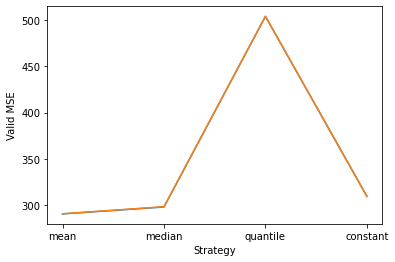

,mean,median,quantile,constant
Train dataset,290.171673,297.676031,504.160785,309.194418
Valid dataset,290.321175,298.025777,504.335722,309.194390


In [14]:
# Plot result of Dummy Regression
print("Dummy Regression MSE of Trian set: ", DRM_train_accuracy)
print("Dummy Regression MSE of Validation set: ", DRM_val_accuracy)

plt.xticks(X_range, strategys)
plt.plot(X_range, DRM_train_accuracy)
plt.plot(X_range, DRM_val_accuracy)
plt.xlabel("Strategy")
plt.ylabel("Valid MSE")

plt.savefig('baseline.png', facecolor='white')
plt.show()
plt.close()
# plt.axhline(DRM_train_accuracy, label = strategys[0])
# plt.axhline(DRM_val_accuracy, label = strategys[0])

# Show the MSE as a dataframe
table = [DRM_train_accuracy, np.array(DRM_val_accuracy)]
train_val_table = pd.DataFrame(table)
train_val_table.columns = strategys
train_val_table.index = ["Train dataset", "Valid dataset"] 
display(train_val_table)
train_val_table.to_latex("baseline_train_val_table.tex")

In [48]:
MSE_dummy_Valid = min(DRM_val_accuracy)
# Predict by baseline model
MSE_dummy_test = test_predict(xtest = Xtest, ytest = Ytest, model =DR_model, polyfeatures = False, degree = 4)

print("MSE in TEST dataset: ", MSE_dummy_test)

MSE in TEST dataset:  295.5139857757798


### **Ridge Regression Model training & test**
1. Model train and time spend
2. Model Test

In [16]:
Time_Start = time.time()

alpha_Range = np.linspace(0, 500, 50)
RRM_mean_train_acc, RRM_mean_val_acc, RRM_moRdel = Ridge_Regression_cv(cv = cv, alpha_Range = alpha_Range, 
                                                                     Xtrain = Xtrain, Ytrain = Ytrain, 
                                                                     polyfeatues = True, degree = 4)
RidgeRegression_time_spend = time.time() - Time_Start
print(RidgeRegression_time_spend)

D:\Anaconda Python\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.57385e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
D:\Anaconda Python\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.56702e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
D:\Anaconda Python\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.55399e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
D:\Anaconda Python\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.55879e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
D:\Anaconda Python\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditio

D:\Anaconda Python\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.77344e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
D:\Anaconda Python\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.7602e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
D:\Anaconda Python\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.76343e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
D:\Anaconda Python\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.7515e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
D:\Anaconda Python\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditione

D:\Anaconda Python\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.76469e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
D:\Anaconda Python\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.73552e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
D:\Anaconda Python\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.74076e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
D:\Anaconda Python\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.71965e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
D:\Anaconda Python\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditio

D:\Anaconda Python\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.55739e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
D:\Anaconda Python\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.51433e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
D:\Anaconda Python\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.52207e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
D:\Anaconda Python\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.49091e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
D:\Anaconda Python\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditio

D:\Anaconda Python\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=7.29315e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
D:\Anaconda Python\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=7.30339e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
D:\Anaconda Python\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=7.26217e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
D:\Anaconda Python\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=7.5522e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
D:\Anaconda Python\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-condition

3.136227607727051


D:\Anaconda Python\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=8.63108e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
D:\Anaconda Python\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=8.605e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
D:\Anaconda Python\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=8.53832e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
D:\Anaconda Python\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=8.55031e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
D:\Anaconda Python\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditione

In [23]:
print("The Ridge Regression model train elapsed {} seconds".format(RidgeRegression_time_spend))

The Ridge Regression model train elapsed 3.136227607727051 seconds


Optimal Hyperpara:  500.0
Optimal MSE:  16.803176325753668


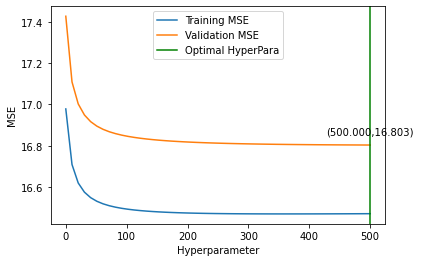

In [17]:
# Plot result of SVR
plot_result(alpha_Range, RRM_mean_train_acc, RRM_mean_val_acc)
plt.savefig('RidgeRegression.png', facecolor='white')
plt.show()
plt.close()

In [52]:
MSE_Ridge_Valid = min(RRM_mean_val_acc)

# Use the returned model to do prediction on test data set
MSE_Ridge_test = test_predict(xtest = Xtest, ytest = Ytest, model = RRM_moRdel, polyfeatures = True, degree = 4)
print("MSE in TEST dataset: ", MSE_Ridge_test)

MSE in TEST dataset:  18.14437489286206


### **Support Vector Regression Model training & test**
1. Model train and time spend
2. Model Test

In [19]:
Time_Start = time.time()

# Call function to Support Vector Regression 
c_range = np.linspace(7e5, 9e5, 5)
SVRM_train_accuracy, SVRM_val_accuracy, SVR_model= SupportVectorRegression(cv = cv, c_Range = c_range, gamma='scale',
                                                                                Xtrain=Xtrain, Ytrain=Ytrain, 
                                                                                polyfeatues = True, degree = 4)
SupportVectorRegression_time_spend = time.time() - Time_Start
print(SupportVectorRegression_time_spend)

509.4843285083771


In [22]:
print("The SVR model train elapsed {} seconds".format(SupportVectorRegression_time_spend))

The SVR model train elapsed 509.4843285083771 seconds


Optimal Hyperpara:  850000.0
Optimal MSE:  18.08782867380931


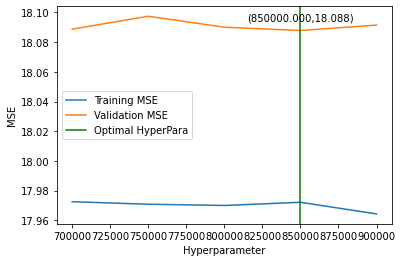

In [20]:
# Plot result of SVR
plot_result(c_range, SVRM_train_accuracy, SVRM_val_accuracy)
plt.savefig('SVR_nonself.png', facecolor='white')
plt.show()
plt.close()

In [49]:
MSE_SVR_Valid = min(SVRM_val_accuracy)

# Use the returned model to do prediction on test data set
MSE_SVR_test = test_predict(xtest = Xtest, ytest = Ytest, model = SVR_model, polyfeatures = True, degree = 4)
print("MSE in TEST dataset: ", MSE_SVR_test)

MSE in TEST dataset:  18.96916209843263


### **Kernel Ridge Regression Model training & test**
1. Model train and time spend
2. Model Test

In [25]:
Time_Start = time.time()

# Call function to Kernel Ridge Regression 
alpha_Range = np.linspace(8e-13, 1e-11, 5)

KRRM_train_accuracy, KRRM_val_accuracy, KRR_model = KernelRidgeRegression(cv = cv, alpha_Range = alpha_Range, 
                                                                          gamma = 1e-5, Xtrain = Xtrain, Ytrain=Ytrain, 
                                                                          polyfeatues = False, degree = 4)

KernelRidgeRegression_time_spend = time.time() - Time_Start
print(KernelRidgeRegression_time_spend)

D:\Anaconda Python\lib\site-packages\sklearn\linear_model\_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=1.21501e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
D:\Anaconda Python\lib\site-packages\sklearn\linear_model\_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=1.15729e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
D:\Anaconda Python\lib\site-packages\sklearn\linear_model\_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=8.67968e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
D:\Anaconda Python\lib\site-packages\sklearn\linear_model\_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=1.10939e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
D:\Anaconda Python\lib\site-packages\sklearn\linear_model\_ridge.py:253: LinAlgWarning: 

86.64542055130005


D:\Anaconda Python\lib\site-packages\sklearn\linear_model\_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=3.88656e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


In [26]:
print("The KRR model train elapsed {} seconds".format(KernelRidgeRegression_time_spend))

The KRR model train elapsed 86.64542055130005 seconds


Optimal Hyperpara:  3.1e-12
Optimal MSE:  16.483609276510233


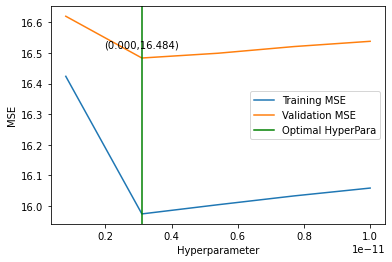

In [27]:
# Plot result of Kernel Redge Regression
plot_result(alpha_Range, KRRM_train_accuracy, KRRM_val_accuracy)
plt.savefig('KernelRidgeRegression.png', facecolor='white')
plt.show()
plt.close()

In [50]:
MSE_KRR_Valid = min(KRRM_val_accuracy)

# Use the returned model to do prediction on test data set
MSE_KRR_test = test_predict(xtest = Xtest, ytest = Ytest, model = KRR_model, polyfeatures = False, degree = 4)
print("MSE in TEST dataset: ", MSE_KRR_test)

MSE in TEST dataset:  17.783593603235005


### **Decision Tree Regression Model training & test**
1. Model train and time spend
2. Model Test

In [29]:
Time_Start = time.time()

# Call function to Kernel Ridge Regression 
Range_depth = range(1, 15)
DTRM_train_accuracy, DTRM_val_accuracy, DTR_model = DecisionTreeRegression(cv = cv, Range_depth = Range_depth, 
                                                                               Xtrain = Xtrain, Ytrain = Ytrain, 
                                                                               polyfeatues = True, degree = 6)
DecisionTreeRegression_time_spend = time.time() - Time_Start
print(DecisionTreeRegression_time_spend)

47.47833275794983


In [30]:
print("The Decision tree model train elapsed {} seconds".format(DecisionTreeRegression_time_spend))

The Decision tree model train elapsed 47.47833275794983 seconds


Optimal Hyperpara:  7
Optimal MSE:  16.934197287894165


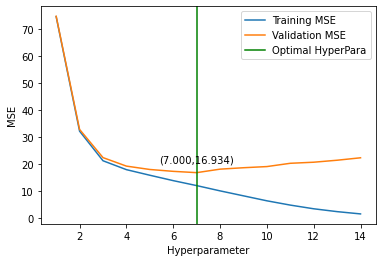

In [31]:
# Plot result of Kernel Redge Regression
plot_result(Range_depth, DTRM_train_accuracy, DTRM_val_accuracy)
plt.savefig('DecisionTreeRegression.png', facecolor='white')
plt.show()
plt.close()

In [54]:
MSE_DecisionTree_Valid = min(DTRM_val_accuracy)

# Use the returned model to do prediction on test data set
MSE_DecisionTree_test = test_predict(xtest = Xtest, ytest = Ytest, model = DTR_model, polyfeatures = True, degree = 6)
print("MSE in TEST dataset: ", MSE_DecisionTree_test)

MSE in TEST dataset:  17.94331000484334


### **Create a result dataframe**
This dataframe will store all test MSEs, valid MSEs, time_spend, number of hyperparameter

In [55]:
Test_MSEs = [MSE_dummy_test, MSE_Ridge_test, MSE_SVR_test, MSE_KRR_test, MSE_DecisionTree_test]
Valid_MSEs = [MSE_dummy_Valid, MSE_Ridge_Valid, MSE_SVR_Valid, MSE_KRR_Valid, MSE_DecisionTree_Valid]
time_spend = [baseline_time_spend, RidgeRegression_time_spend, 
              SupportVectorRegression_time_spend, KernelRidgeRegression_time_spend, 
              DecisionTreeRegression_time_spend]
num_hyperpara = [4, 50, 5, 5, 15]

In [75]:
valid_results_table = [np.array(Valid_MSEs), np.array(Test_MSEs), np.array(time_spend), np.array(num_hyperpara)]
MSE_time_table = pd.DataFrame(valid_results_table)
MSE_time_table.columns = ["Base", "RR", "SVR", 
                           "KRR", "DTR"]
MSE_time_table.index = ["Valid_MSEs", "Test_MSEs", "Time_elapsed(s)", "Hy-para num"] 
MSE_time_table = MSE_time_table.T
display(MSE_time_table)
MSE_time_table.to_latex("MSE_time_table.tex")



,Valid_MSEs,Test_MSEs,Time_elapsed(s),Hy-para num
Base,290.321175,295.513986,0.020219,4.0
RR,16.803176,18.144375,3.136228,50.0
SVR,18.087829,18.969162,509.484329,5.0
KRR,16.483609,17.783594,86.645421,5.0
DTR,16.934197,17.943310,47.478333,15.0
